# Module 4 Project: Financial Instrument Time Series Analysis - Techincal Notebook
### Andrew Cole

In [42]:
#Import necessary libraries, including Helper.py module

import ticker_cleaner
import pandas as pd
import stationarity_check
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as TS
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm;

import warnings

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Gathering Financial Data and Visualizing Historic Movement

In [27]:
#Use ticker_cleaner module to perform all data gathering and organization into Pandas DF for operation.

xlv_monthly_mean = ticker_cleaner.yahoo_finance_clean('XLV')
xlv_monthly_mean

,Close
Date,
2020-01-01,101.850000
2019-12-01,100.354762
2019-11-01,95.596500
2019-10-01,90.148696
2019-09-01,89.694500
...,...
1999-04-01,21.752857
1999-03-01,20.773913
1999-02-01,20.173684


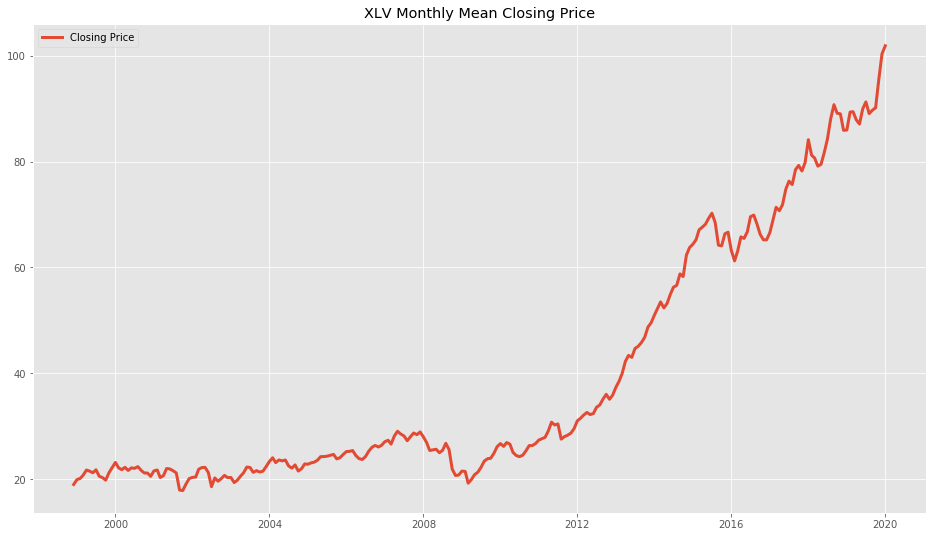

<Figure size 432x288 with 0 Axes>

In [28]:
# Plot the historic movement of XLV's Monthly Mean Closing Price

warnings.filterwarnings(action='always')
plt.style.use('ggplot')
fig = plt.figure(figsize = (16,9))
plt.plot(xlv_monthly_mean, linewidth = 3, label = 'Closing Price')
plt.title('XLV Monthly Mean Closing Price')
plt.legend()
plt.show();
plt.savefig('XLV_beginning_close_price')


## Decomposition

In [29]:
# Use seasonal decomposition function from statsmodels library to seasonally decompose the XLV series after it has been log-transformed

decomposition = seasonal_decompose(np.log(xlv_monthly_mean))

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

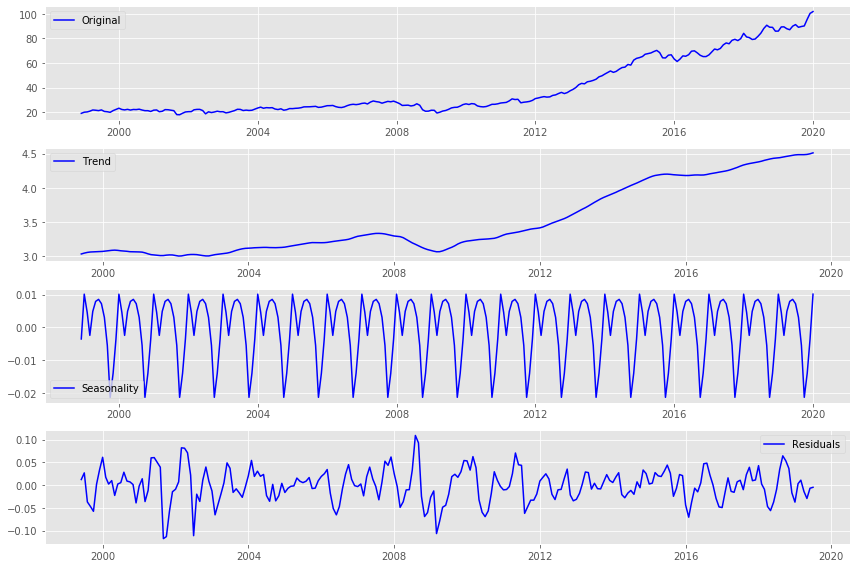

In [30]:
#Visualize trend, seasonality, and residual distribution individually

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(xlv_monthly_mean, label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

## Stationarity Check

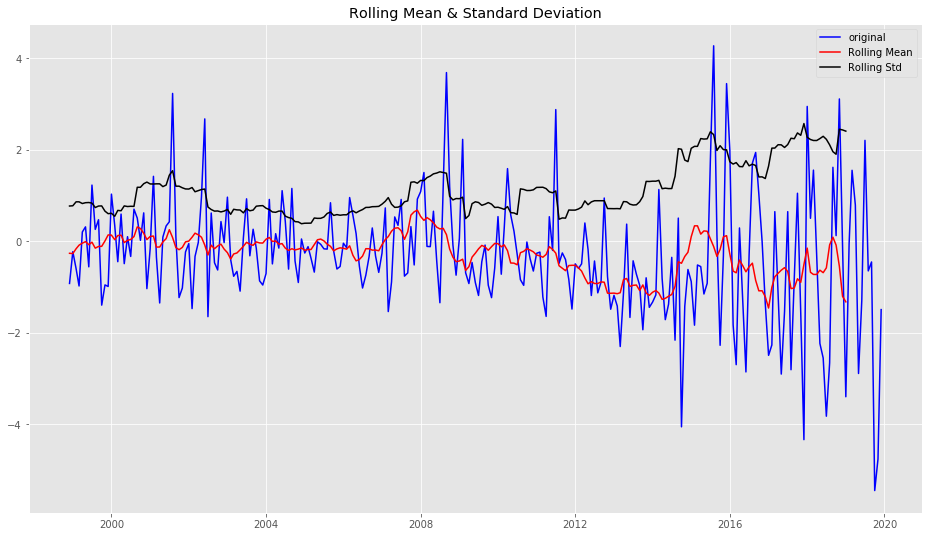

Results of Dickey-Fuller Test
Test Statistic                -1.188268e+01
p-value                        6.125220e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


In [34]:
# Take a one period difference of the means and perform a stationarity check(Dickey-Fuller Test). Null Hypothesis: The series is NOT stationary.

xlv_differenced_mean = xlv_monthly_mean.diff(periods = 1).dropna()
stationarity_check.stationarity_check(xlv_differenced_mean.Close)

In [35]:
# We can reject the null hypothesis and say that the series is now stationary.

## Model Optimization

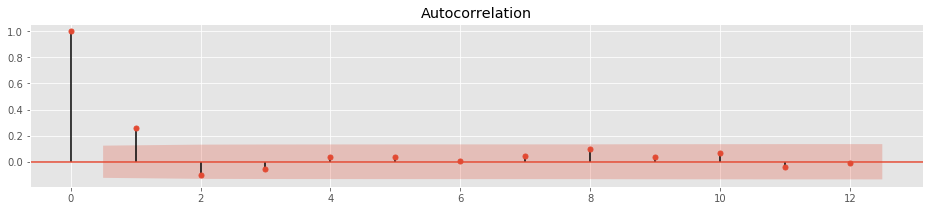

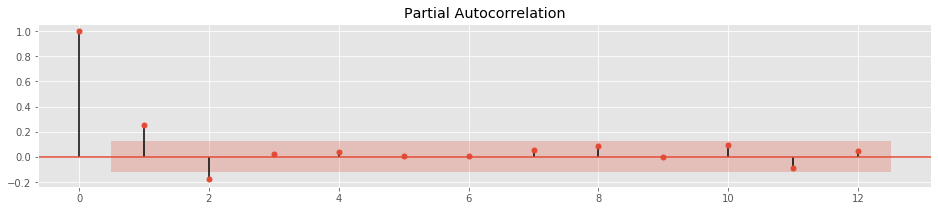

In [40]:
#Plot ACF and PACF functions to get Autoregressive and Moving Average parameters 
fig, ax = plt.subplots(figsize = (16,3))
plot_acf(xlv_differenced_mean, ax = ax, lags = 12);

fig, ax = plt.subplots(figsize = (16,3))
plot_pacf(xlv_differenced_mean, ax=ax, lags = 12);

In [44]:
# Run a SARIMA model with order (1,1,2)x(1,1,2,12) to account for seasonality as well. 
mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean, trend='n', order=(1,1,2), seasonal_order=(1,1,2,12));
res = mod.fit();
res.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -408.761
Date:                            Wed, 08 Jan 2020   AIC                            831.522
Time:                                    12:29:09   BIC                            855.916
Sample:                                01-01-2020   HQIC                           841.350
                                     - 12-01-1998                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2934      0.486      0.604      0.546      -0.659       1.245
ma.L1          0.0047      0.485      0.010      0.992      -0.946       0.956
ma.L2         -0.1950      0.147     -1.328      0.184      -0.483       0.093
ar.S.L12      -0.9996      0.066    -15.141      0.000      -1.129      -0.870
ma.S.L12       0.1520      0.641      0.237      0.813      -1.105       1.409
ma.S.L24      -0.8345      0.551     -1.514      0.130      -1.915       0.246
sigma2         1.5764      0.898      1.756      0.079      -0.183       3.335
===================================================================================
Ljung-Box (Q):                       31.26   Jarque-Bera (JB):               137.62
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
# Run a second SARIMA model with order (1,1,1)x(1,1,1,12)) to account for seasonality as well
mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean, trend='n', order=(1,1,1), seasonal_order=(1,1,1,12))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -412.090
Date:                            Wed, 08 Jan 2020   AIC                            834.181
Time:                                    12:30:32   BIC                            851.605
Sample:                                01-01-2020   HQIC                           841.201
                                     - 12-01-1998                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2007      0.169     -1.188      0.235      -0.532       0.130
ma.L1          0.5181      0.155      3.350      0.001       0.215       0.821
ar.S.L12      -0.0765      0.057     -1.351      0.177      -0.187       0.034
ma.S.L12      -0.8336      0.062    -13.395      0.000      -0.956      -0.712
sigma2         1.6751      0.104     16.149      0.000       1.472       1.878
===================================================================================
Ljung-Box (Q):                       31.48   Jarque-Bera (JB):               136.13
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Auto-ARIMA